## Random Forest Classifier

This notebook contains the code for the random forest classifier, which is 'trained' with a dataset transformed with PCA.

In [1]:
# Imported libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

In [2]:
# Loading in raw image files, which are encoded as row-vectors.
mfeat_pix = np.loadtxt("./mfeat-pix.txt")

# Splitting the data into a training and testing dataset.
trainPatterns = np.concatenate((mfeat_pix[0:100], mfeat_pix[200:300], 
                               mfeat_pix[400:500], mfeat_pix[600:700],
                               mfeat_pix[800:900], mfeat_pix[1000:1100],
                               mfeat_pix[1200:1300], mfeat_pix[1400:1500],
                               mfeat_pix[1600:1700], mfeat_pix[1800:1900]))

testPatterns = np.concatenate((mfeat_pix[100:200], mfeat_pix[300:400], 
                               mfeat_pix[500:600], mfeat_pix[700:800],
                               mfeat_pix[900:1000], mfeat_pix[1100:1200],
                               mfeat_pix[1300:1400], mfeat_pix[1500:1600],
                               mfeat_pix[1700:1800], mfeat_pix[1900:2000]))

# Create indicator matrices size 10 x 1000 with the class labels coded by 
# binary indicator vectors.
b = np.array([1]*100)

# Create a row vector of correct class labels (from 0 ... 9 for the 10
# classes). This vector is the same for training and testing.
correctLabels = np.concatenate((b*0, b, b*2, b*3, b*4, b*5, b*6, b*7, b*8, b*9))

In [3]:
# Defining some useful function(s).

def convert_to_images(data, indices, shape=(15, 16)):
    
    images = []
    for i in indices:
        pic = data[i]
        picmatreverse = np.zeros(shape)
        picmatreverse = -np.reshape(pic, (shape[1], shape[0])).T
        picmat = np.zeros(shape)
        for k in range(0, shape[0]):
            picmat[:, k] = picmatreverse[:, shape[0]-k]
        images.append(picmat.T)
        
    return images

def plot_images(images, indices, rows=5, columns=10, figsize=(15, 15)):
    figs, subplots = plt.subplots(rows, columns, sharex=True, sharey=True, figsize=figsize)
    
    for i in range(0, rows):
        for j in range(0, columns):
            subplots[i, j].pcolor(images[i*columns+j], cmap="gray")
            correctLabel = correctLabels[indices[i*columns+j]] 
            assignedLabel = labels_pred[indices[i*columns+j]]
            subplots[i, j].set_title("C: {}; A: {}".format(correctLabel, assignedLabel))

    plt.show()

## Grid search with Random Forest: 5-fold Cross-Validation

In [4]:
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

np.random.seed(42)

pcs = np.arange(20, 120, 20)
results = {}

for n in pcs:

    pca = PCA(n_components = n)
    pca_train = pca.fit_transform(trainPatterns)

    # Setting up the random forest classifier.
    rf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2, 
                                min_samples_leaf=1, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, 
                                bootstrap=False,  ccp_alpha=0.0)   

    # Dictionary containing the parameter values that we want to test.
    param_grid = {'n_estimators': np.arange(40, 120, 5), 'criterion': ['gini', 'entropy'], 
                  'max_depth': [None, 20, 40, 60, 80, 100]}
    # Using gridsearch to test all values for the chosen parameters.
    rf_gscv = GridSearchCV(rf, param_grid, cv=5)
    # Fitting model to data.
    rf_gscv.fit(pca_train, correctLabels)
    
    results['{}'.format(n)] = (rf_gscv.best_score_, rf_gscv.best_params_)
    

In [5]:
print(results)

{'20': (0.9570000000000001, {'criterion': 'gini', 'max_depth': 80, 'n_estimators': 115}), '40': (0.9629999999999999, {'criterion': 'gini', 'max_depth': 100, 'n_estimators': 105}), '60': (0.9640000000000001, {'criterion': 'gini', 'max_depth': 40, 'n_estimators': 110}), '80': (0.962, {'criterion': 'gini', 'max_depth': 40, 'n_estimators': 105}), '100': (0.96, {'criterion': 'gini', 'max_depth': 20, 'n_estimators': 75})}


## Random Forest Classifier

In [6]:
# Random forest classifier:
# n_estimators: number of trees in the forest
# criterion (function to measure the quality of a split): 'gini' (Gini impurity)
# max_depth = None (maximum depth) [reconsider integer max depth? --> 100]
# min_samples_split = 2 (minimum number of samples required to split an internal node)
# min_samples_leaf = 1 (minimum number of samples required to be at a leaf node)
# max_features = 'sqrt' (i.e., max_features=sqrt(n_features); number of features to consider when looking for best split)
# max_leaf_nodes = None (unlimited number of leaf nodes in tree)
# bootstrap = False (whole dataset is used to build each tree)
# ccp_alpha = 0.0 (default; no pruning performed) 

estimatores_best = 110
criterion_best = 'gini'
depth_best = 40

rf_clf = RandomForestClassifier(n_estimators=estimatores_best, criterion=criterion_best, max_depth=depth_best, 
                                min_samples_split=2, 
                                min_samples_leaf=1, max_features='sqrt', max_leaf_nodes=None, 
                                min_impurity_decrease=0.0, 
                                bootstrap=False,  ccp_alpha=0.0) 

Accuracy on test data: 88.80%


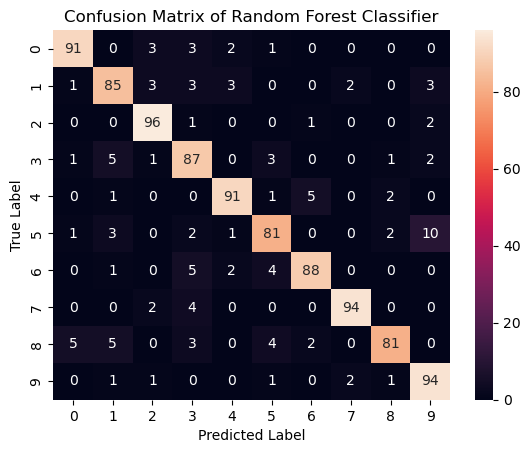

In [7]:
# Running classifier without 5-fold cross-validation.
np.random.seed(42)

n_best = 60
pca = PCA(n_components = n_best)
pca_train = pca.fit_transform(trainPatterns)
pca_test = pca.fit_transform(testPatterns)

model = rf_clf.fit(pca_train, correctLabels)
labels_pred = model.predict(pca_test)

# Accuracy score
accuracy = accuracy_score(correctLabels, labels_pred)
print("Accuracy on test data: {:.2f}%".format(accuracy*100))

# Confusion matrix
conf_mat = confusion_matrix(correctLabels, labels_pred)

# Plotting the confusion matrix of the kNN classifier.
image = sns.heatmap(conf_mat, annot=True, 
                    #cmap='Blues', 
                    fmt='g')
plt.title("Confusion Matrix of Random Forest Classifier")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## Plotting Some Misclassified Test Images

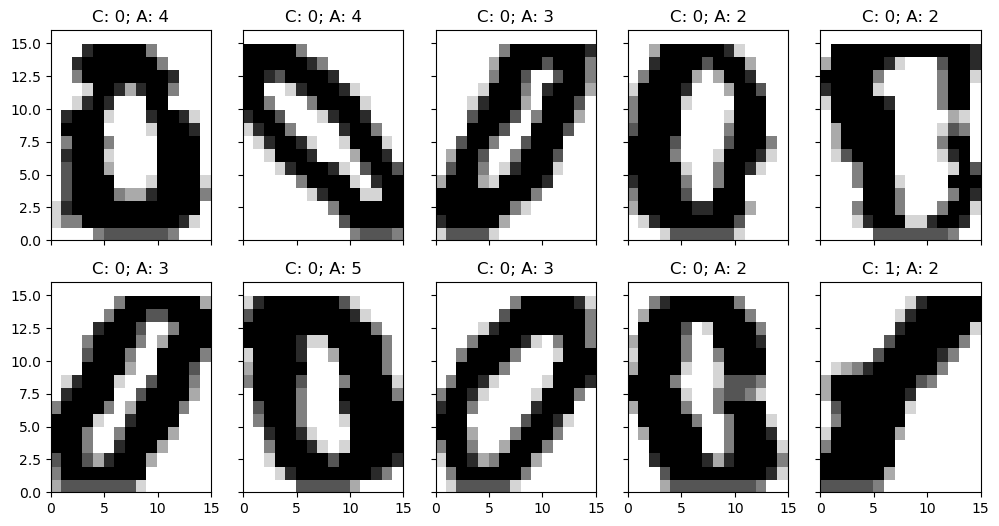

In [8]:
indMisclassifiedTest = np.where(correctLabels != labels_pred)[0]

imagesMisclassifiedTest = convert_to_images(testPatterns, indMisclassifiedTest)

plot_images(imagesMisclassifiedTest, indMisclassifiedTest, rows=2, columns=5, figsize=(12, 6))